                               LIQUID STAKING DERIVATIVE INDEX OPTIMIZATION

This project aims to optimize the weights of The Liquid Staked ETH index (LSETH) using Genetic Algorithms. The index token contains an equal-weighted basket (20%) of the 5 leading liquid staked Ether derivatives to reduce volatility and mitigate underlying protocol risk compared to holding individual tokens.

Downloading historical prices

In [1]:
import requests
import pandas as pd
from datetime import datetime

index = [
   "rocket-pool-eth",
    "wrapped-steth",
    "staked-frax-ether",
    "coinbase-wrapped-staked-eth",
    "ankreth",
    "liquid-staked-eth-index"
]

data_list = []

for name in index:
    url = f"https://api.coingecko.com/api/v3/coins/{name}/market_chart"
    parameters = {
        "vs_currency": "eth",
         "days": "150"
    }
    response = requests.get(url, params=parameters)

    if response.status_code == 200:
        data = response.json()
        prices = data["prices"]
        for price in prices:
            timestamp = price[0] / 1000  # Convert milliseconds to seconds
            price_value = price[1]
            date = pd.to_datetime(timestamp, unit='s').strftime("%Y-%m-%d")
            data_list.append([name, date, price_value])
    else:
        print(f"Error occurred while retrieving data for {name}.")

# Create a DataFrame from the collected data
df1 = pd.DataFrame(data_list, columns=["Name", "Date", "Price"])
df1 = df1.sort_values("Date")
df1.set_index("Date", inplace=True)

df1

,Name,Price
Date,,
2023-01-14,rocket-pool-eth,1.066057
2023-01-14,ankreth,1.029341
2023-01-14,coinbase-wrapped-staked-eth,0.989050
2023-01-14,staked-frax-ether,1.013796
2023-01-14,wrapped-steth,1.096555
...,...,...
2023-06-12,coinbase-wrapped-staked-eth,1.037875
2023-06-12,rocket-pool-eth,1.073881
2023-06-12,rocket-pool-eth,1.073363


In [2]:
pivot_df1 = df1.pivot_table(index=df1.index, columns='Name', values='Price')
pivot_df1

Name,ankreth,coinbase-wrapped-staked-eth,liquid-staked-eth-index,rocket-pool-eth,staked-frax-ether,wrapped-steth
Date,,,,,,
2023-01-14,1.029341,0.989050,NaN,1.066057,1.013796,1.096555
2023-01-15,1.026785,0.987951,NaN,1.066722,1.015723,1.097225
2023-01-16,1.004351,0.987675,NaN,1.064756,1.015964,1.096141
2023-01-17,0.973837,0.990344,NaN,1.069676,1.013531,1.099075
2023-01-18,1.030344,0.994129,NaN,1.064854,1.012423,1.098706
...,...,...,...,...,...,...
2023-06-08,1.114097,1.037160,NaN,1.074116,1.043340,1.126638
2023-06-09,1.117357,1.037402,NaN,1.074398,1.043445,1.127916
2023-06-10,1.112879,1.037661,NaN,1.074277,1.042319,1.126968


Imputing missing values

In [3]:

from sklearn.impute import KNNImputer

# Step 1: Load the pivot_df DataFrame
# Assuming you have already loaded the pivot_df DataFrame

# Step 2: Define the KNN imputer
imputer = KNNImputer(n_neighbors=5)

# Step 3: Perform KNN imputation
imputed_data = imputer.fit_transform(pivot_df1)

# Step 4: Convert the imputed data back to a DataFrame
pivot_df1 = pd.DataFrame(imputed_data, index=pivot_df1.index, columns=pivot_df1.columns)

# Print the imputed DataFrame
pivot_df1

Name,ankreth,coinbase-wrapped-staked-eth,liquid-staked-eth-index,rocket-pool-eth,staked-frax-ether,wrapped-steth
Date,,,,,,
2023-01-14,1.029341,0.989050,1.011608,1.066057,1.013796,1.096555
2023-01-15,1.026785,0.987951,1.011608,1.066722,1.015723,1.097225
2023-01-16,1.004351,0.987675,1.013843,1.064756,1.015964,1.096141
2023-01-17,0.973837,0.990344,1.015541,1.069676,1.013531,1.099075
2023-01-18,1.030344,0.994129,1.011608,1.064854,1.012423,1.098706
...,...,...,...,...,...,...
2023-06-08,1.114097,1.037160,0.995802,1.074116,1.043340,1.126638
2023-06-09,1.117357,1.037402,0.993350,1.074398,1.043445,1.127916
2023-06-10,1.112879,1.037661,0.995616,1.074277,1.042319,1.126968


Plotting Returns and Volatilities

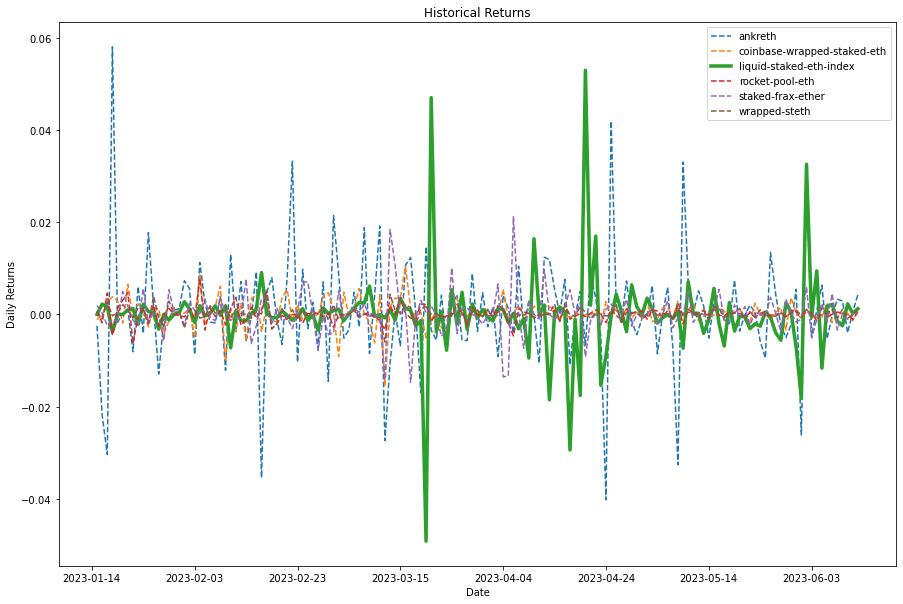

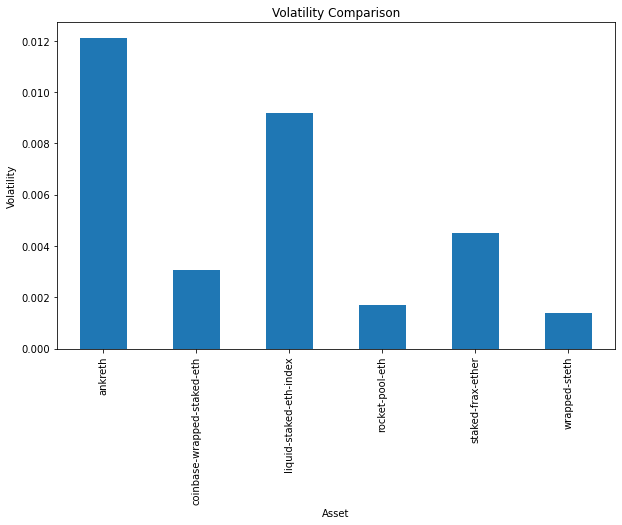

In [4]:
import matplotlib.pyplot as plt

# Calculate daily returns
returns = pivot_df1.pct_change()

# Calculate volatility (standard deviation of returns)
volatility = returns.std()

# Plotting the returns
plt.figure(figsize=(15, 10))
for col in returns.columns:
    if col == 'liquid-staked-eth-index':
        returns[col].plot(ax=plt.gca(), label=col, linewidth=3.5)
    else:
        returns[col].plot(ax=plt.gca(), linestyle='--', label=col)
plt.ylabel('Daily Returns')
plt.title('Historical Returns')
plt.legend()
plt.show()

# Plotting the volatility
plt.figure(figsize=(10, 6))
volatility.plot(kind='bar')
plt.xlabel('Asset')
plt.ylabel('Volatility')
plt.title('Volatility Comparison')
plt.show()

We can actually see that LSETH index shows a bigger volatilty compared to most liquid staked derivatives...

Downloading individual token historical prices

In [5]:
cryptocurrencies = [
    "rocket-pool-eth",
    "wrapped-steth",
    "staked-frax-ether",
    "coinbase-wrapped-staked-eth",
    "ankreth"
]

data_list = []

for name in cryptocurrencies:
    url = f"https://api.coingecko.com/api/v3/coins/{name}/market_chart"
    parameters = {
        "vs_currency": "eth",
         "days": "150"
    }
    response = requests.get(url, params=parameters)

    if response.status_code == 200:
        data = response.json()
        prices = data["prices"]
        for price in prices:
            timestamp = price[0] / 1000  # Convert milliseconds to seconds
            price_value = price[1]
            date = pd.to_datetime(timestamp, unit='s').strftime("%Y-%m-%d")
            data_list.append([name, date, price_value])
    else:
        print(f"Error occurred while retrieving data for {name}.")

# Create a DataFrame from the collected data
df2 = pd.DataFrame(data_list, columns=["Name", "Date", "Price"])
df2 = df2.sort_values("Date")
df2.set_index("Date", inplace=True)

df2

,Name,Price
Date,,
2023-01-14,rocket-pool-eth,1.066057
2023-01-14,ankreth,1.029341
2023-01-14,wrapped-steth,1.096555
2023-01-14,coinbase-wrapped-staked-eth,0.989050
2023-01-14,staked-frax-ether,1.013796
...,...,...
2023-06-12,staked-frax-ether,1.043032
2023-06-12,staked-frax-ether,1.042480
2023-06-12,ankreth,1.119722


In [6]:
pivot_df2 = df2.pivot_table(index=df2.index, columns='Name', values='Price')
pivot_df2

Name,ankreth,coinbase-wrapped-staked-eth,rocket-pool-eth,staked-frax-ether,wrapped-steth
Date,,,,,
2023-01-14,1.029341,0.989050,1.066057,1.013796,1.096555
2023-01-15,1.026785,0.987951,1.066722,1.015723,1.097225
2023-01-16,1.004351,0.987675,1.064756,1.015964,1.096141
2023-01-17,0.973837,0.990344,1.069676,1.013531,1.099075
2023-01-18,1.030344,0.994129,1.064854,1.012423,1.098706
...,...,...,...,...,...
2023-06-08,1.114097,1.037160,1.074116,1.043340,1.126638
2023-06-09,1.117357,1.037402,1.074398,1.043445,1.127916
2023-06-10,1.112879,1.037661,1.074277,1.042319,1.126968


In [7]:
# Step 1: Define the KNN imputer
imputer = KNNImputer(n_neighbors=5)

# Step 2: Perform KNN imputation
imputed_data = imputer.fit_transform(pivot_df2)

# Step 3: Convert the imputed data back to a DataFrame
pivot_df2 = pd.DataFrame(imputed_data, index=pivot_df2.index, columns=pivot_df2.columns)
pivot_df2

Name,ankreth,coinbase-wrapped-staked-eth,rocket-pool-eth,staked-frax-ether,wrapped-steth
Date,,,,,
2023-01-14,1.029341,0.989050,1.066057,1.013796,1.096555
2023-01-15,1.026785,0.987951,1.066722,1.015723,1.097225
2023-01-16,1.004351,0.987675,1.064756,1.015964,1.096141
2023-01-17,0.973837,0.990344,1.069676,1.013531,1.099075
2023-01-18,1.030344,0.994129,1.064854,1.012423,1.098706
...,...,...,...,...,...
2023-06-08,1.114097,1.037160,1.074116,1.043340,1.126638
2023-06-09,1.117357,1.037402,1.074398,1.043445,1.127916
2023-06-10,1.112879,1.037661,1.074277,1.042319,1.126968


Downloading historical LSETH prices

In [8]:
cryptocurrency = [
    "liquid-staked-eth-index"
]

data_list = []

for name in cryptocurrency:
    url = f"https://api.coingecko.com/api/v3/coins/{name}/market_chart"
    parameters = {
        "vs_currency": "eth",
        "days": "150"
    }
    response = requests.get(url, params=parameters)

    if response.status_code == 200:
        data = response.json()
        prices = data["prices"]
        for price in prices:
            timestamp = price[0] / 1000  # Convert milliseconds to seconds
            price_value = price[1]
            date = datetime.fromtimestamp(timestamp).strftime("%Y-%m-%d")
            data_list.append([name, date, price_value])
    else:
        print(f"Error occurred while retrieving data for {name}.")

# Create a DataFrame from the collected data
df_index= pd.DataFrame(data_list, columns=["Name", "Date", "Price"])


# Sort DataFrame by "Date"
df_index = df_index.sort_values("Date")
df_index.set_index("Date", inplace=True)
df_index

,Name,Price
Date,,
2023-01-28,liquid-staked-eth-index,1.010372
2023-01-29,liquid-staked-eth-index,1.010372
2023-01-30,liquid-staked-eth-index,1.010793
2023-01-31,liquid-staked-eth-index,1.013571
2023-02-01,liquid-staked-eth-index,1.014740
...,...,...
2023-05-28,liquid-staked-eth-index,0.989419
2023-05-29,liquid-staked-eth-index,0.989939
2023-05-30,liquid-staked-eth-index,1.000700


In [9]:
# Drop the 'Name' column
df_index.drop('Name', axis=1, inplace=True)

# Replace the 'Price' column with 'liquid-staked-eth-index'
df_index.rename(columns={'Price': 'liquid-staked-eth-index'}, inplace=True)
df_index

,liquid-staked-eth-index
Date,
2023-01-28,1.010372
2023-01-29,1.010372
2023-01-30,1.010793
2023-01-31,1.013571
2023-02-01,1.014740
...,...
2023-05-28,0.989419
2023-05-29,0.989939
2023-05-30,1.000700


Running the Optimization 

In [10]:
import random
import numpy as np
from deap import base, creator, tools, algorithms

# Define the currency names
cryptocurrencies = cryptocurrencies

# Calculate the variances
variance = pivot_df2.var()

# Calculate the covariances
covariance_matrix = pivot_df2.cov()

# Step 1: Define the Problem - Objective Function
def calculate_portfolio_risk(weights, covariance_matrix):
    portfolio_variance = np.dot(weights, np.dot(covariance_matrix, weights))
    return portfolio_variance

def normalize_weights(weights):
    sum_weights = sum(weights)
    normalized_weights = [(w / sum_weights) * 100 for w in weights]
    bounded_weights = [max(0, min(w, 100)) for w in normalized_weights]
    return bounded_weights

def evaluate(individual):
    # Calculate portfolio risk (variance) based on weights
    weights = normalize_weights(individual)
    risk = calculate_portfolio_risk(weights, covariance_matrix)
    return -risk,  # Negative sign to minimize the risk

# Define the components and number of currencies
components = cryptocurrencies
num_currencies = len(components)

population_size = 100
num_generations = 50

# Step 2: Define the Individual Representation
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# Step 3: Define the Genetic Operators
toolbox = base.Toolbox()
toolbox.register("attribute", random.uniform, 0, 100)  # Range set to (0, 100)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attribute, n=num_currencies)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=10, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

# Step 4: Define the Evolutionary Algorithm
population = toolbox.population(n=population_size)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)

algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=num_generations, stats=stats, halloffame=hof)

# Step 5: Retrieve the best individual and its corresponding weights
best_individual = hof[0]
best_weights = normalize_weights(best_individual)
sum_weights = sum(best_weights)
best_weights = [w * 100 / sum_weights for w in best_weights]

print("Best Portfolio Weights:")
for currency, weight in zip(components, best_weights):
    print(currency + ": " + str(weight))

gen	nevals	min     
0  	100   	-4.13222
1  	62    	-4.13222
2  	65    	-6.20346
3  	53    	-8.88222
4  	55    	-13.8234
5  	61    	-15.1673
6  	59    	-19.3968
7  	55    	-20.9374
8  	69    	-26.8735
9  	63    	-26.8735
10 	58    	-26.8735
11 	64    	-27.1369
12 	70    	-27.1369
13 	65    	-27.4495
14 	68    	-27.4495
15 	66    	-27.4495
16 	62    	-27.4495
17 	53    	-27.4495
18 	69    	-27.4495
19 	71    	-27.4495
20 	64    	-27.4495
21 	61    	-27.4495
22 	72    	-27.4495
23 	60    	-27.4495
24 	57    	-27.4495
25 	57    	-27.4495
26 	50    	-27.4495
27 	57    	-27.4495
28 	68    	-27.4495
29 	60    	-27.4495
30 	71    	-27.4495
31 	60    	-27.4495
32 	54    	-27.4495
33 	65    	-27.4495
34 	53    	-27.4495
35 	53    	-27.4495
36 	64    	-27.4495
37 	61    	-27.4495
38 	70    	-27.4495
39 	63    	-27.4495
40 	62    	-27.4495
41 	68    	-27.4495
42 	62    	-27.4495
43 	71    	-27.4495
44 	53    	-27.4495
45 	53    	-27.4495
46 	61    	-27.4495
47 	59    	-27.4495
48 	60    	-27.4495


In [11]:
# Create a DataFrame with currency-weight pairs
weights_df = pd.DataFrame({'Weight': best_weights}, index=components)
weights_df.index.name = 'Currency'

In [12]:
weights_df['Weight'] = weights_df['Weight'] / 100
weights_df

,Weight
Currency,
rocket-pool-eth,0.25
wrapped-steth,0.25
staked-frax-ether,0.25
coinbase-wrapped-staked-eth,0.00
ankreth,0.25


In [13]:
# Multiply each column of pivot_df by the corresponding weight
weighted_pivot_df = pivot_df2.multiply(weights_df['Weight'], axis=1)

In [14]:
# Calculate the historical cumulative sum of the weights
weighted_pivot_df['Optimized Basket'] = weighted_pivot_df.sum(axis=1)
weighted_pivot_df

,ankreth,coinbase-wrapped-staked-eth,rocket-pool-eth,staked-frax-ether,wrapped-steth,Optimized Basket
Date,,,,,,
2023-01-14,0.257335,0.0,0.266514,0.253449,0.274139,1.051437
2023-01-15,0.256696,0.0,0.266680,0.253931,0.274306,1.051613
2023-01-16,0.251088,0.0,0.266189,0.253991,0.274035,1.045303
2023-01-17,0.243459,0.0,0.267419,0.253383,0.274769,1.039030
2023-01-18,0.257586,0.0,0.266213,0.253106,0.274677,1.051582
...,...,...,...,...,...,...
2023-06-08,0.278524,0.0,0.268529,0.260835,0.281659,1.089548
2023-06-09,0.279339,0.0,0.268599,0.260861,0.281979,1.090779
2023-06-10,0.278220,0.0,0.268569,0.260580,0.281742,1.089111


In [15]:
weighted_pivot_df = weighted_pivot_df.loc['2023-01-28':]

Merging Weighted Sum with liquid-staked-eth

In [16]:
# Merge the two DataFrames based on the index
merged_df = weighted_pivot_df.merge(df_index, left_index=True, right_index=True)

In [17]:
merged_df=merged_df[['Optimized Basket','liquid-staked-eth-index']]
merged_df

,Optimized Basket,liquid-staked-eth-index
Date,,
2023-01-28,1.052382,1.010372
2023-01-29,1.054681,1.010372
2023-01-30,1.055026,1.010793
2023-01-31,1.055542,1.013571
2023-02-01,1.055853,1.014740
...,...,...
2023-05-28,1.088206,0.989419
2023-05-29,1.087445,0.989939
2023-05-30,1.087158,1.000700


Plotting the graphs

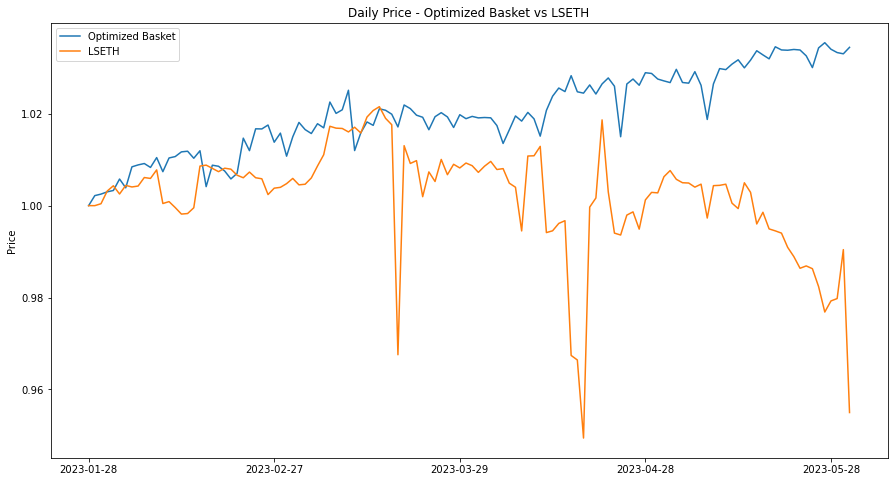

In [18]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(15, 8))

# Set price data to start at 1
normalized_optimized_basket = merged_df['Optimized Basket'] / merged_df['Optimized Basket'].iloc[0] * 1
normalized_lseth = merged_df['liquid-staked-eth-index'] / merged_df['liquid-staked-eth-index'].iloc[0] * 1

# Plot normalized price data
ax.plot(merged_df.index, normalized_optimized_basket, label='Optimized Basket')
ax.plot(merged_df.index, normalized_lseth, label='LSETH')
ax.set_ylabel('Price')
ax.set_title('Daily Price - Optimized Basket vs LSETH')
ax.legend()

# Set tick frequency to show dates every 30 days
ax.xaxis.set_major_locator(ticker.MultipleLocator(30))

plt.show()


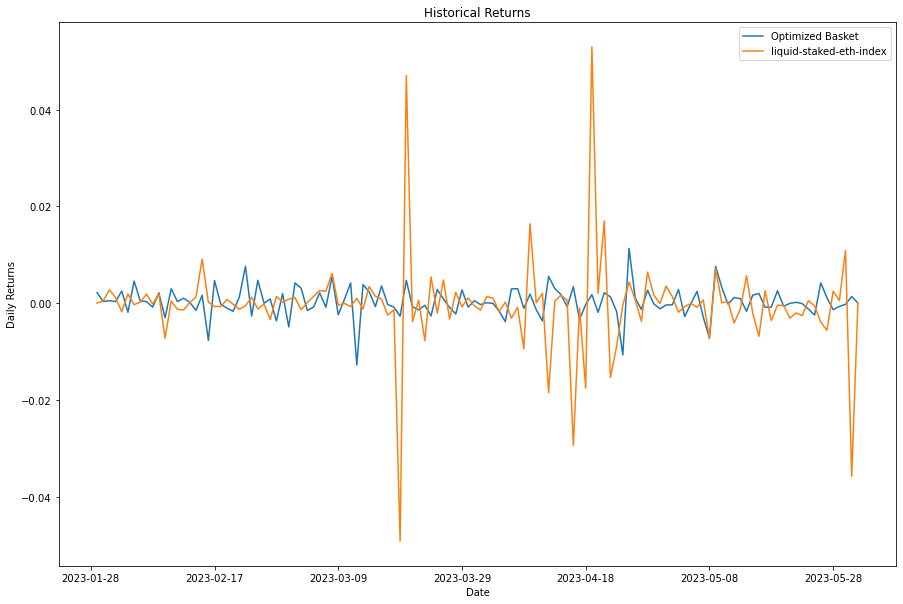

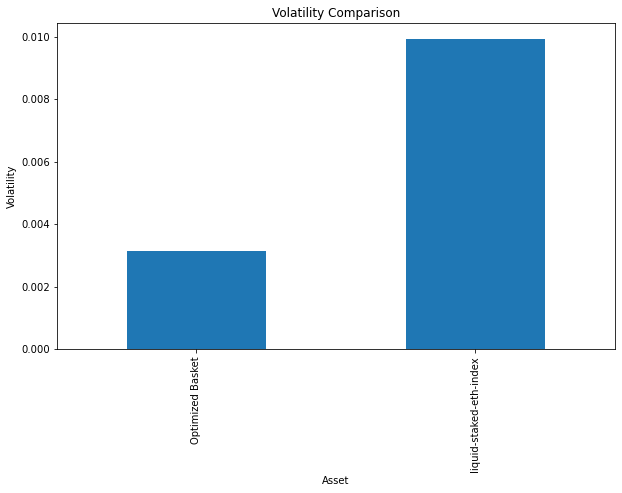

In [19]:
# Calculate daily returns
returns = merged_df[['Optimized Basket','liquid-staked-eth-index',]].pct_change()

# Calculate volatility (standard deviation of returns)
volatility = returns.std()

# Plotting the returns
plt.figure(figsize=(15, 10))
returns.plot(ax=plt.gca())
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.title('Historical Returns')
plt.legend()
plt.show()

# Plotting the volatility
plt.figure(figsize=(10, 6))
volatility.plot(kind='bar')
plt.xlabel('Asset')
plt.ylabel('Volatility')
plt.title('Volatility Comparison')
plt.show()



We can see that the Optimized Basket generated better returns and lower volatilty. The optimized basket has 4 liquid staking derivatives, which can still provide some diversification and mitigate underlying protocol risk compared to holding individual tokens.